In [1]:
# Forecasting Output Active Power using GRU and LSTM

# =============================
# STEP 1: Import Libraries
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# =============================
# STEP 2: Load and Prepare Data
# =============================

# Load the signals data
signals_df = pd.read_csv("signals_exported.csv")

# Create time-based features (simply use time steps since no true datetime)
signals_df['Hour'] = (signals_df['time'] % 24).astype(np.float32)

# Select features and target
target_column = 'Output_active_power___Peo__pu_'
feature_columns = [col for col in signals_df.columns if col not in ['time', target_column]]

X = signals_df[feature_columns]
y = signals_df[[target_column]]

# Normalize features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [3]:
# =============================
# STEP 3: Create Sliding Windows
# =============================

LOOKBACK_WINDOW = 7 * 24  # 168 time steps
FUTURE_HORIZON = 24       # 24 time steps ahead

X_data, Y_data = [], []

for i in range(len(X_scaled) - LOOKBACK_WINDOW - FUTURE_HORIZON):
    X_data.append(X_scaled[i:i+LOOKBACK_WINDOW])
    Y_data.append(y_scaled[i+LOOKBACK_WINDOW:i+LOOKBACK_WINDOW+FUTURE_HORIZON].flatten())

X_data = np.array(X_data, dtype=np.float32)
Y_data = np.array(Y_data, dtype=np.float32)

# Split into train/test
split_idx = int(len(X_data) * 0.8)

X_train, X_test = X_data[:split_idx], X_data[split_idx:]
Y_train, Y_test = Y_data[:split_idx], Y_data[split_idx:]

# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# =============================
# STEP 4: Model Definitions
# =============================

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 128).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 128).to(x.device)
        c0 = torch.zeros(2, x.size(0), 128).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize models
input_size = X_train.shape[2]
model_gru = GRUModel(input_size=input_size, hidden_size=128, num_layers=2, output_size=24)
model_lstm = LSTMModel(input_size=input_size, hidden_size=128, num_layers=2, output_size=24)

In [5]:
# =============================
# STEP 5: Training Loop
# =============================

criterion = nn.HuberLoss()
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gru.to(device)
model_lstm.to(device)

num_epochs = 10

# Train GRU
for epoch in range(num_epochs):
    model_gru.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_gru.zero_grad()
        outputs = model_gru(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_gru.step()
    print(f'GRU Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

# Train LSTM
for epoch in range(num_epochs):
    model_lstm.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_lstm.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_lstm.step()
    print(f'LSTM Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

GRU Epoch [1/10] Loss: 0.0001
GRU Epoch [2/10] Loss: 0.0001
GRU Epoch [3/10] Loss: 0.0000
GRU Epoch [4/10] Loss: 0.0000
GRU Epoch [5/10] Loss: 0.0000
GRU Epoch [6/10] Loss: 0.0000
GRU Epoch [7/10] Loss: 0.0000
GRU Epoch [8/10] Loss: 0.0000
GRU Epoch [9/10] Loss: 0.0000
GRU Epoch [10/10] Loss: 0.0000
LSTM Epoch [1/10] Loss: 0.0001
LSTM Epoch [2/10] Loss: 0.0000
LSTM Epoch [3/10] Loss: 0.0001
LSTM Epoch [4/10] Loss: 0.0000
LSTM Epoch [5/10] Loss: 0.0000
LSTM Epoch [6/10] Loss: 0.0001
LSTM Epoch [7/10] Loss: 0.0000
LSTM Epoch [8/10] Loss: 0.0000
LSTM Epoch [9/10] Loss: 0.0000
LSTM Epoch [10/10] Loss: 0.0000


GRU Metrics: RMSE=0.0643, MAE=0.0164, R2=0.4786, CVRMSE=0.0812
LSTM Metrics: RMSE=0.0656, MAE=0.0220, R2=0.4582, CVRMSE=0.0828


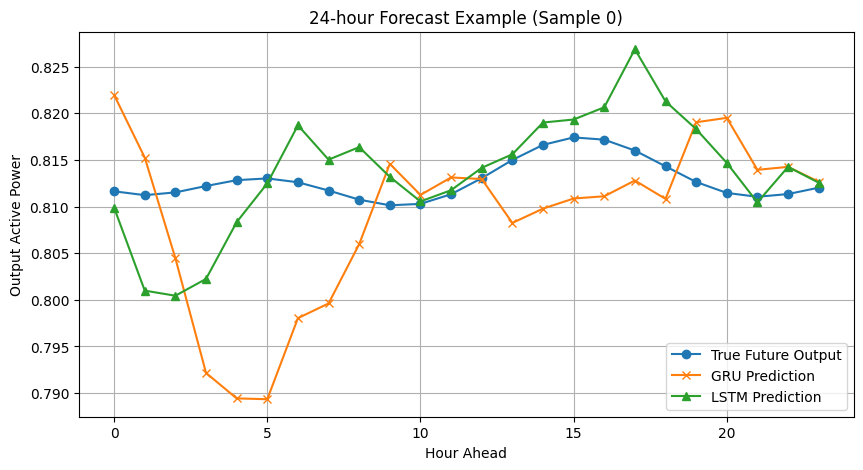

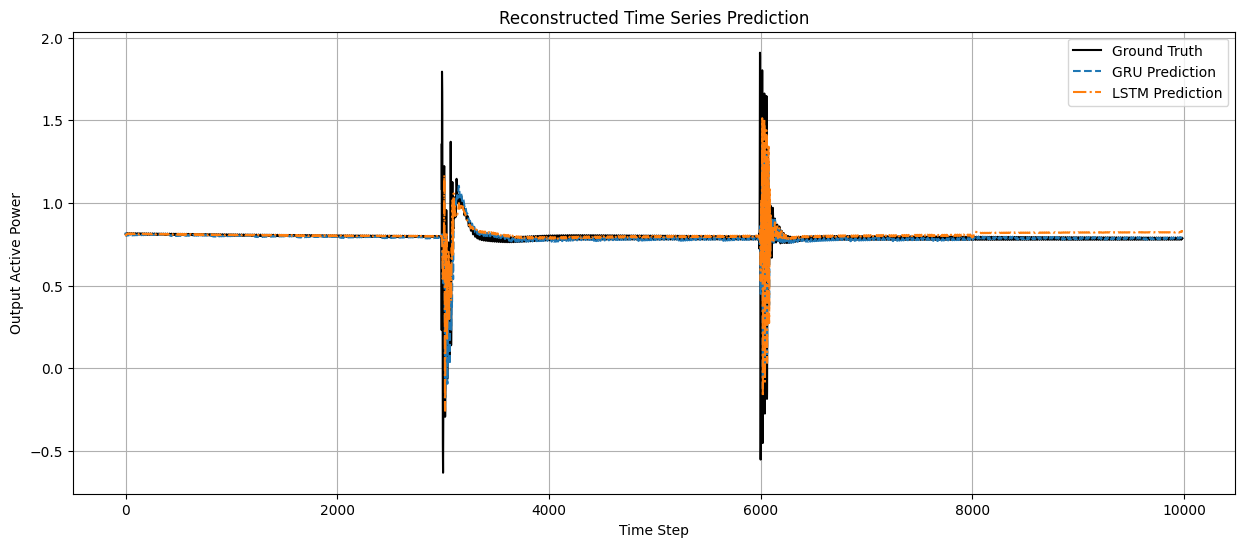

In [9]:
# =============================
# STEP 6: Batched Evaluation + Visualization
# =============================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Batched evaluation
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model_gru.eval()
model_lstm.eval()

gru_preds_list = []
lstm_preds_list = []
y_true_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        
        gru_outputs = model_gru(inputs)
        lstm_outputs = model_lstm(inputs)

        gru_preds_list.append(gru_outputs.cpu().numpy())
        lstm_preds_list.append(lstm_outputs.cpu().numpy())
        y_true_list.append(targets.cpu().numpy())

gru_preds = np.concatenate(gru_preds_list, axis=0)
lstm_preds = np.concatenate(lstm_preds_list, axis=0)
Y_test_true = np.concatenate(y_true_list, axis=0)

# Inverse transform
Y_test_true_inv = scaler_y.inverse_transform(Y_test_true)
gru_preds_inv = scaler_y.inverse_transform(gru_preds)
lstm_preds_inv = scaler_y.inverse_transform(lstm_preds)

# Metrics calculation
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    cvrmse = rmse / np.mean(y_true)
    return rmse, mae, r2, cvrmse

rmse_gru, mae_gru, r2_gru, cvrmse_gru = calculate_metrics(Y_test_true_inv.flatten(), gru_preds_inv.flatten())
rmse_lstm, mae_lstm, r2_lstm, cvrmse_lstm = calculate_metrics(Y_test_true_inv.flatten(), lstm_preds_inv.flatten())

print(f"GRU Metrics: RMSE={rmse_gru:.4f}, MAE={mae_gru:.4f}, R2={r2_gru:.4f}, CVRMSE={cvrmse_gru:.4f}")
print(f"LSTM Metrics: RMSE={rmse_lstm:.4f}, MAE={mae_lstm:.4f}, R2={r2_lstm:.4f}, CVRMSE={cvrmse_lstm:.4f}")


# -------------------------
# Visualization 1: Loss Curves
# (Optional if you saved training losses. If not skip.)
# -------------------------

# Visualization 2: First Sample 24-hour Forecast
import matplotlib.pyplot as plt
hours = np.arange(24)

sample_index = 0
true_sample = Y_test_true_inv[sample_index]
gru_pred_sample = gru_preds_inv[sample_index]
lstm_pred_sample = lstm_preds_inv[sample_index]

plt.figure(figsize=(10, 5))
plt.plot(hours, true_sample, label='True Future Output', marker='o')
plt.plot(hours, gru_pred_sample, label='GRU Prediction', marker='x')
plt.plot(hours, lstm_pred_sample, label='LSTM Prediction', marker='^')
plt.xlabel('Hour Ahead')
plt.ylabel('Output Active Power')
plt.title('24-hour Forecast Example (Sample 0)')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------
# Visualization 3: Reconstructed Long Time Series
# -------------------------

# Reconstruct sequences
def reconstruct_sequence(windows):
    total_length = windows.shape[0] + 24 - 1
    result = np.zeros(total_length)
    count = np.zeros(total_length)
    for i in range(windows.shape[0]):
        result[i:i+24] += windows[i]
        count[i:i+24] += 1
    return result / count

reconstructed_true = reconstruct_sequence(Y_test_true_inv)
reconstructed_gru = reconstruct_sequence(gru_preds_inv)
reconstructed_lstm = reconstruct_sequence(lstm_preds_inv)

# Time axis
time_axis = np.arange(len(reconstructed_true))

plt.figure(figsize=(15, 6))
plt.plot(time_axis, reconstructed_true, label='Ground Truth', color='black')
plt.plot(time_axis, reconstructed_gru, label='GRU Prediction', linestyle='--')
plt.plot(time_axis, reconstructed_lstm, label='LSTM Prediction', linestyle='-.')
plt.xlabel('Time Step')
plt.ylabel('Output Active Power')
plt.title('Reconstructed Time Series Prediction')
plt.legend()
plt.grid(True)
plt.show()

